#**SHARK ATTACK FILE**
---

De Shark Attack File is gemaakt door een organisatie die opkomt voor de haai. De tabel wordt met uiterste zorg samengesteld. Wetenschappers bestuderen elk incident en maken een rapport hiervan die in de tabel is opgenomen. Door die openheid probeert de organisatie zo objectief mogelijk te zijn. De tabel is te downloaden via https://www.sharkattackfile.net/spreadsheets/GSAF5.xls



**Vragen:**

**1.   Wat zijn voor mensen de meest gevaarlijke haaiensoorten?**

**2.   hebben kinderen meer kans door haaien aangevallen te worden?**

**3.   zijn aanvallen van haaien die worden uitgelokt meer of minder gevaarlijk?**

**4.   Hebben bepaalde activiteiten meer kans op een aanval van een haai?**

---



# **INITIALISATIE + DOWNLOADEN SHARK ATTACK FILE**
---

De dataset van Kaggle.com is niet up-to-date. Het XLS bestand van Sharkattackfile.net is dat wel.Om een XLS bestand in Colab te kunnen gebruiken, moet XLRD van 1.1 naar 1.2 worden geupdate. In de initialisatie wordt deze update uitgevoerd. Na de update moet, indien aangegeven, de runtime ververst wordt. 

In [2]:
#@title <-- Klik om te starten { run: "auto", vertical-output: true, display-mode: "form" }
# Upgrade verouderde versie XLRD vereist voor importeren van xls sheet. Runtime restart noodzakelijk. 
!pip install xlrd==1.2.0

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%load_ext google.colab.data_table

# het bestand op https://www.kaggle.com/datasets/felipeesc/shark-attack-dataset was niet volledig en up to date.
df = pd.read_excel('https://www.sharkattackfile.net/spreadsheets/GSAF5.xls')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 103 kB 31.5 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


## **TABEL VEREENVOUDIGEN**

Er ontbreken redelijk veel gegevens in de tabel. De meeste velden zijn kwalitatief en categorisch van aard en lege velden zijn niet door een "gemiddelde" of andere algoritme in te vullen. Afhankelijk van de vragen uit de opdracht kunnen sommige incidenten niet worden opgenomen in de berekeningen. Hierdoor zal er een bias kunnen ontstaan. Per vraag wordt hier dieper op ingegaan.

In de code hieronder worden alleen kolommen verwijderd die voor geen enkele vraag uit de opdracht van belang zijn. Lege of foutieve waarden worden omgezet naar NaN. Enkele incidenten waarbij wetenschappers hebben vastgesteld dat er geen haai in het spel was, zijn verwijderd

In [3]:
#@title <--klik om tabel te vereenvoudigen { run: "auto", vertical-output: true }
# een nieuwe dataframe met alleen de noodzakelijke kolommen.
df_sharks = df.iloc[:,:14].drop(columns=['Year','Date', 'Area', 'Location', 'Name', 'Sex ', 'Time'])

# verkort de namen en verwijder spaties uit enkele kolomnamen
df_sharks.columns = ['Type', 'Country','Activity', 'Age', 'Injury','Fatal', 'Species']


# ****KOLOM TYPE****

# vervang klein aantal NaN's door "unprovoked". Uit bestudering blijken deze "unprovoked" te moeten zijn
df_sharks['Type'].replace(np.nan, 'Unprovoked', inplace=True)

# verwijder incidenten met: invalid, questionable, Sea Disaster en unconfirmed in kolom Type, omdat onduidelijk is of hier een haai betrokken is
type_mask = df_sharks['Type'].isin(['Invalid','Questionable','Sea Disaster', 'Unconfirmed','?']) == False
df_sharks = df_sharks.loc[type_mask,:]


# ****KOLOM ACTIVITY****

# vervang aantal foutieve waardes met NAN
df_sharks['Activity'].replace(
    {'.' : np.nan,
     ' ' : np.nan,
     'unknown' : np.nan}, inplace=True) 


# ****KOLOM AGE****

# functie die woorden als Teen en Adult omzet in een leeftijd
# daarna filtert de functie leeftijden uit strings en daarvan het gemiddelde berekenen
def age_changer(age):
  try:
    if 'teen' in age.lower() or 'minor' in age.lower():
      return 17
    if 'young' in age.lower():
      return 11
    if 'months' in age.lower():
      return 1
    if 'adult' in age.lower() or 'elderly' in age.lower():
      return 18
    ages = age.strip('\&|\+|\?|\-|\!\' |\'|s|s\'') #soms staan er tekens achter een getal die hiermee worden weggehaald.
    ages = re.split('\&|\+|or|to|s|\?|and|\-|\!|\'',ages) #de strings worden gesplitst in getallen
    int_ages = [eval(i) for i in ages] # de getallen in de list worden omgezet naar integers
    avg_age = round( sum(int_ages) / len(int_ages), 0) # het gemiddelde van de getallen in de list
    return avg_age
  except:
    return age

# de functie age_changer toepassen op kolom Age
df_sharks['Age']=df_sharks['Age'].transform(age_changer)

# Overige waardes in kolom Age omzetten naar leeftijden of NaN's
df_sharks['Age'].replace(
    {
     '!!' : np.nan,
     'M': np.nan,
     '\xa0 ' : np.nan,
     '6½' : 6,
     'Both 11': 11,
     '>50' : 50,
     'MAKE LINE GREEN' : np.nan,
     '28, 23 & 30' : 27,
     '22, 57, 31' : 36,
     'mid-30s' : 35,
     '"middle-age"' :50,
     'X' : np.nan,
     '  ' : np.nan,
     ' ' : np.nan,
     'A.M.' : np.nan,
     '?    &   14' : 14,
     '2½' : 3
     },inplace=True)


# getallen van het stringtype omzetten naar float.
df_sharks['Age'] = df_sharks['Age'].transform(lambda age: float(age) if type(age) is str else age)


# ****KOLOM INJURY****

# vervang aantal foutieve of lege waardes in kolom Injury voor NAN's
df_sharks['Injury'].replace(
    {'No details' : np.nan,
     '' : np.nan,
     'unknown' : np.nan}, inplace=True) 


# ****KOLOM SPECIES****

# vervang aantal foutieve of lege waardes in kolom Species vor NaN's
df_sharks['Species'].replace(
    {' ' : np.nan,
     '' : np.nan,
     'Unknown' : np.nan,
     None : np.nan}, inplace=True)


# ****KOLOM FATAL****

# vervang een aantal velden in kolom Fatal
df_sharks['Fatal'].replace(
    {'M' : 'N',
     'n' : 'N',
     'Nq': 'N',
     2017 : 'N',
     'UNKNOWN' : np.nan}, inplace=True)

# vervang daarna alle Y/N door 1/0 (makkelijker bij berekeningen)
df_sharks['Fatal'].replace({
    'Y' : 1,
    'N' :0,
    'N ':0
}, inplace=True)


## **TABEL UITBREIDINGEN**

Voor de beantwoording van de vragen, moet de tabel worden uitgebreid met nieuwe kolommen. 

- Voor vraag 1 en 3, een paar kolommen waarbij wordt aangegeven of het incident zonder verwondingen, met verwondingen of fataal is afgelopen.

- Voor vraag 1, een kolom waarbij de type van de haai wordt aangegeven. Hierdoor is het mogelijk de incidenten op type haai weer te geven.

- Voor vraag 1, een kolom waarbij de grootte van de haai wordt aangegeven. Hierdoor is het mogelijk de incidenten op haai grootte weer te geven.

- Voor vraag 4, een kolom waarbij de activiteiten zijn samengevat in een aantal hoofdgroepen. Hierdoor krijgt men inzicht in de correlatie tussen de afloop van het incident en activiteiten die op elkaar lijken. Het groeperen van deze activiteiten moet zeer zorgvuldig gebeuren omdat een verkeerde indeling een enorm scheef beeld geeft en er daarmee een bias optreedt. Het groeperen van de activiteiten is gedaan aan de hand van informatie afkomstig van de Floridamudeum. https://www.floridamuseum.ufl.edu/shark-attacks/factors/victim-activity/

- Voor vraag 2, een kolom waarbij de leeftijden per 6 jaar zijn gecategoriseerd naar "0 t/m 5", "6 t/m 11", "12 t/m 17", "18 t/m 23", enz enz. Er is bewust niet voor twee groepen (kinderen/volwassenen) gekozen, omdat er grote fysieke verschillen zijn tussen kleine en grotere kinderen en dit een belangrijke oorzaak kan zijn in de afloop van de haaienaanval. Door de verdeling in meerdere groepen zou de invloed van bijvoorbeeld fysieke eigenschappen zichtbaar kunnen worden.  

Meer informatie over de kolommen en groepenindeling vind je bij de behandeling van de vraag.


In [4]:
#@title <-- Klik om tabel met extra kolommen uit te breiden { run: "auto", vertical-output: true }
# **** TOEVOEGING KOLOM INJURY_GRP****

# categoriseer kolom Injury naar: No_injury, Injured en Fatal. Try Except om foutmeldingen te voorkomen
def group_injury(injury):
  groups = {'no injury'   : ['no injur','no injury'],
            'injured'     : ['non-fatal'],
            'fatal'       : ['fatal','killed']
            }
  try:
    for groupname in (groups):
      for i in range(len(groups[groupname])):
        if groups[groupname][i] in injury.lower():
          return groupname
    return 'injured'  
  except:
    return np.nan

# maak kolom INJURY_GRP
df_sharks['injury_grp'] = df_sharks['Injury'].transform(group_injury)



# **** TOEVOEGING KOLOM INJURED****

# zoek rijen met 'injured' in kolom INJURY_GRP
def is_injured(injury):
  return 1 if injury == 'injured' else 0

# maak de kolom INJURED
df_sharks['injured']=df_sharks['injury_grp'].transform(is_injured)


# **** TOEVOEGING KOLOM NO_INJURY ****

# functie: zoek rijen met 'no injury' in kolom INJURY_GRP.
def no_injury(injury):
  return 1 if injury == 'no injury' else 0


# maak kolom NO_INJURY
df_sharks['no_injury'] = df_sharks['injury_grp'].transform(no_injury)


# **** AANPASSING KOLOM fatal ****

# na bestudering van kolom 'injury', 'Fatal' en 'injury_grp' bleek de reeds bestaande kolom 'Fatal' een paar fouten te hebben die kolom injury_grp niet had
# Soms stond "Fatal" in kolom 'injury' en 'N' in kolom 'Fatal'. daarom is de oude kolom vervangen

# functie: zoek rijen met 'fatat' in kolom INJURY_GRP.
def is_fatal(injury):
  return 1 if injury == 'fatal' else 0


# vervang de oude kolom 'Fatal'
df_sharks['Fatal'] = df_sharks['injury_grp'].transform(is_fatal)



# ****TOEVOEGING KOLOM ACTIVITY_GRP****


# groeperen kolom activity naar enkele hoofdactiviteiten: Spearfishing, Fishing, Surfing, Swimming enz
def group_activity(activity):
  groups = {'fishing' : ['spearfishing','fishing','lobstering','fihing','feeding','catch','collecting','nett','hunt','spear','crab'],
            'surfing' : ['surfing','surfng','kite surfing','kite','scurf','surf','ski','parasailing'],
            'swimming': ['swimming','swmming','snorkling','snorkeling','lifeguard exercises','treading','bathing','rescu','lifesav','escap'],
            'walking' : ['standing','washing','wading','squatting','walking','sitting'],
            'floating': ['floating','boarding','body boarding','float','inflatable','body'],
            'playing' : ['playing','jump','splash','fell','drop','overboard','dive','dangling'],
            'shark'   : ['shark','research'],
            'murdering':['murder'],
            'rowing'  : ['kayak','rowing','canoe','sightseeing','paddling','kakaying','sup'],
            'sailing' : ['sailing','cruis','yacht','boat','racing','ship','watercraft'],
            'diving'  : ['scuba diving', 'free diving','cage diving','scalloping','diving','photo','film','shrimp','scull','clamm']}
  try:
    for groupname in (groups):
      for i in range(len(groups[groupname])):
        if groups[groupname][i] in activity.lower():
          return groupname
    return 'other'  
  except:
    return np.nan

df_sharks['activity_grp'] = df_sharks['Activity'].transform(group_activity)


# ****TOEVOEGING KOLOM AGE_GRP****


# functie om leeftijden te groeperen

def group_by_age(age):
  if age < 6: return '05'
  elif age < 10: return '11'
  elif age < 18: return  '17'
  elif age < 24: return '23'
  elif age < 30: return '29'
  elif age < 36: return '35'
  elif age < 42: return '41'
  elif age < 48: return '47'
  elif age < 54: return '53'
  elif age < 60: return '59'
  elif age < 65: return '64'
  elif age >= 65: return '65+'
  else: return np.nan

# toevoeging van de kolom
df_sharks['age_grp'] = df_sharks['Age'].transform(group_by_age)



# ****TOEVOEGING KOLOM SHARK_TYPE****


# haaien naar grootte groeperen
def group_by_size(size):
  if size < 5: return '0-5 feet sharks'
  elif size < 10: return '5-10 feet sharks'
  elif size < 15: return  '10-15 feet sharks'
  else: return '>=15 feet sharks'

# groeperen kolom Species naar de belangrijkste haaisoorten
def group_sharks(species):
  sharks = {'White shark'         : ['white ','while'],
            'Tiger shark'         : [' tiger','tiger '],
            'Bronze whaler shark' : ['bronze'],
            'Whaler shark'        : ['wahler','whaler'],
            'Whitetip shark'      : ['whitetip'],
            'Silvertip shark'     : ['silver'],
            'Blue pointer shark'  : ['pointer'],
            'Blue shark'          : ['blue'], 
            'Hammerhead shark'    : ['hammerhead'],
            'Shortfin Mako shark' : ['mako'],
            'Blacktip shark'      : ['blacktip'],
            'Sandtiger shark'     : ['sandtiger'],
            'Raggedtooth shark'   : ['raggedtooth'],
            'Grey nurse shark'    : ['grey','gray'],
            'Nurse shark'         : ['nurse'],
            'Lemon shark'         : ['lemon'],
            'Carpet shark'        : ['carpet'],
            'Bull shark'          : ['bull'],
            'Epaulette shark'     : ['epaulet'],
            'Wobbegong shark'     : ['wobbegong'],
            'Sevengill shark'     : ['sevengil','seven gill','7-gill'],
            'Dogfish shark'       : ['dog','dogfish'],
            'Spinner shark'       : ['spinner'],
            'Galapagos shark'     : ['galapagos'],
            'Tope shark'          : ['tope'],
            'Juvenile shark'      : ['juvenile'],
            'Angel shark'         : ['angel'],
            'Reef shark'          : ['reef'],
            'Shovelnose shark'    : ['shovel'],
            'Basking shark'       : ['basking'],
            'Zambesi shark'       : ['zambesi','zambezi'],
            'Porbeagle shark'     : ['pobeagle'],
            'Sandbar shark'       : ['sand'],
            'Bonita shark'        : ['bonita'],
            'Horn shark'          : ['horn'],
            'Dusky shark'         : ['dusky'],
            'Copper shark'        : ['copper'],
            'Leopard shark'       : ['leopard'],
            'Goblin shark'        : ['goblin'],
            'Cow shark'           : ['cow'],
            'Salmon shark'        : ['salmon'],
            }
  try:
    for sharkname in (sharks):
      for i in range(len(sharks[sharkname])):
        if sharks[sharkname][i] in species.lower():
          return sharkname
    return np.nan 
  except:
    return np.nan

# toevoegen van kolom shark_type
df_sharks['shark_type'] = df_sharks['Species'].transform(group_sharks)


# ****TOEVOEGING KOLOM SHARK_SIZE****


# groeperen kolom Species naar haai grootte
def group_shark_size(species):
  try:
    # groeperen op basis van grootte in feet          
    if 'shark' in species.lower() and ("']" in species.lower() or '"]' in species.lower()):
      split = re.split('\[|\'\]|\"\]',species)
      sliced = split[1]
      try:
        shark_size =int(sliced)
        return group_by_size(shark_size)
      except:
        try:
          sliced = re.split('\-|\' to|\" to|to|and',sliced)
          nmbr = [eval(i) for i in sliced]
          shark_size = round(sum(nmbr) / len(nmbr),1)
          return group_by_size(shark_size)
        except:
          return np.nan
    elif 'shark' in species.lower() and ("'" in species.lower() or '"' in species.lower()):
      split = re.split('\'|\"',species)
      sliced = split[0]
      split = re.split(' ',sliced)
      sliced = split[-1]
      try:
        shark_size =int(sliced)
        return group_by_size(shark_size)
      except:
        try:
          sliced = re.split('\-|\' to|\" to|to|and',sliced)
          nmbr = [eval(i) for i in sliced]
          shark_size = round(sum(nmbr) / len(nmbr),1) 
          return group_by_size(shark_size)
        except:
          return np.nan
    # als groeperen op feet niet kan dan groeperen op basis van grootte in meters          
    elif 'shark' in species.lower() and "m" in species.lower():
      split = re.split('m| m',species) # eerste split
      sliced = split[0]
      split = re.split(' ',sliced) # tweede split
      sliced = split[-1] # pak de laatste waarde in de lijst
      try:
        shark_size =int(sliced)
        shark_size = shark_size * 3 # omzetten naar feet
        return group_by_size(shark_size)
      except:
        try:
          sliced = re.split('\-|\' to|\" to|to|and',sliced)
          nmbr = [eval(i) for i in sliced]
          shark_size = round(sum(nmbr) / len(nmbr),1)
          shark_size = shark_size * 3 # omzetten naar feet
          return group_by_size(shark_size) 
        except:
          return np.nan # als error dan np.nan 
    elif 'shark' in species.lower() and ("small" in species.lower() or "dog" in species.lower()):
      return '0-5 feet sharks'
    return np.nan # als het lengte niet kan worden bepaald dan np.nan
  except:
    return np.nan # als error dan np.nan

df_sharks['shark_size'] = df_sharks['Species'].transform(group_shark_size)

#**VRAAG 1) Wat zijn voor mensen de meest gevaarlijke haaiensoorten?**
---

Wat is de definitie van gevaarlijk bij deze vraag? Zouden we alleen het aantal incidenten van iedere type haai in beschouwing nemen en afzetten tegen het totaal aantal incidenten, dan zou onderstaande lijst ontstaan. Uit tabel 1 blijkt dat de Witte Haai veruit de gevaarlijkste haai zou zijn.   




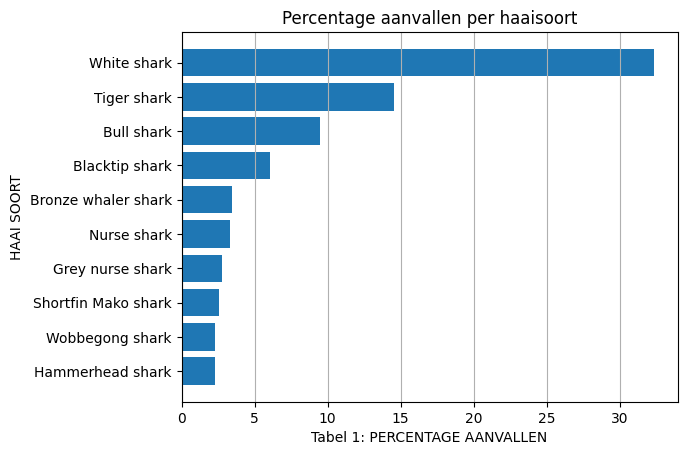

In [5]:
#@title <-- klik voor Tabel 1 { run: "auto", vertical-output: true }

# maak vraag 1 een nieuwe dataframe en verwijder de overbodige kolommen
df_sharks_q1 = df_sharks.drop(columns=['Activity','Age','Injury','Species','activity_grp','age_grp'])

# verwijder rijen met lege waarden in kolom Shark of Injury
df_sharks_q1.dropna(subset=['shark_type','injury_grp'], inplace=True)

# groepeer de dataframe op kolom shark_type
df_sharks_q1_tbl1 = round((df_sharks_q1['shark_type'].value_counts() / df_sharks_q1['shark_type'].count())*100,2)

# X,Y AS
X = df_sharks_q1_tbl1.unique()[0:10] # eerste tien soorten
Y = df_sharks_q1_tbl1.index.get_level_values(0)[0:10]

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
error = 0

# drawing chart
ax.barh(Y, X, xerr=error, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Tabel 1: PERCENTAGE AANVALLEN')
ax.set_ylabel('HAAI SOORT')
ax.set_title('Percentage aanvallen per haaisoort')
ax.xaxis.grid()
plt.show()


In bovenstaande tabel 1 is alleen rekening gehouden met het totaal aantal aanvallen ongeacht de situatie of aanleiding van de aanval. Zouden mensen vaker op de "witte haai" jagen dan is het logisch dat de witte haai een hogere score heeft. Dit kan een bias veroorzaken en die zou eruit gefilterd moeten worden. In tabel 2 hieronder zien we dat de resultaten bijna onveranderd zijn. Ongeacht provocatie of niet, blijft de Witte Haai, wat betreft het aantal aanvallen, nog steeds de gevaarlijkste.

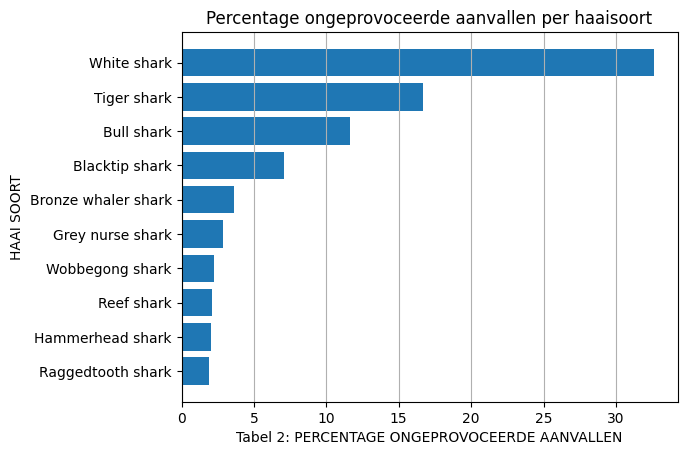

In [6]:
#@title <-- Klik voor Tabel 2 { run: "auto", vertical-output: true }
# Nieuw dataframe voor tabel 2 met alleen Unprovoked incidenten
df_sharks_q1_tbl2 = df_sharks_q1.loc[df_sharks_q1['Type']=='Unprovoked']

# percentage aanvallen gesorteerd op haaien soort
df_sharks_q1_tbl2 = round((df_sharks_q1_tbl2['shark_type'].value_counts() / df_sharks_q1_tbl2['shark_type'].count())*100,2)
# X,Y AS
X = df_sharks_q1_tbl2.unique()[0:10] # eerste tien soorten
Y = df_sharks_q1_tbl2.index.get_level_values(0)[0:10]

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
error = 0

# drawing chart
ax.barh(Y, X, xerr=error, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Tabel 2: PERCENTAGE ONGEPROVOCEERDE AANVALLEN')
ax.set_ylabel('HAAI SOORT')
ax.set_title('Percentage ongeprovoceerde aanvallen per haaisoort')
ax.xaxis.grid()
plt.show()

In bovenstaande tabel 2 gaat het weliswaar alleen om het aantal ongeprovoceerde aanvallen van iedere willekeurige haai, maar er is geen rekening gehouden met de gevolgen van die aanval. Is een haai ondanks zijn vele aanvallen wel als gevaarlijk te classificeren als die haai door gebrek aan grootte en scherp gebit geen kwaad kan doen? Ik denk van niet. Als alleen de fatale aanvallen als meest gevaarlijk worden betiteld, resulteert dit in onderstaande tabel 3 met meest gevaarlijke haaien.

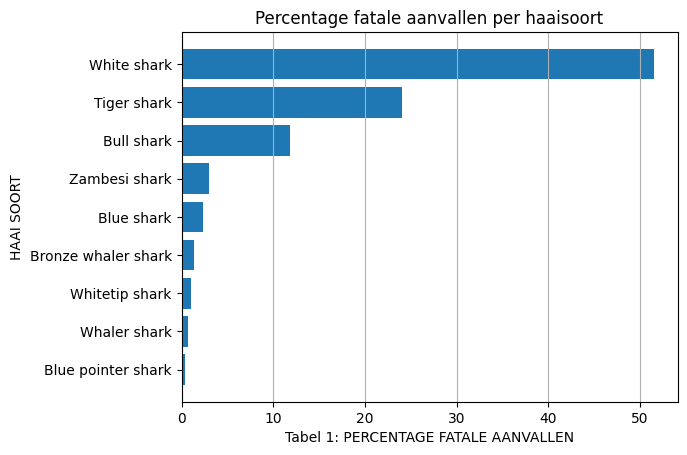

In [7]:
#@title <-- Klik voor tabel 3 { run: "auto", vertical-output: true }
# Nieuw dataframe voor tabel 3 met alleen Unprovoked incidenten
df_sharks_q1_tbl3 = df_sharks_q1[df_sharks_q1['Type']=='Unprovoked']

# Alleen de fatale aanvallen van df_sharks_q1_tbl3
df_sharks_q1_tbl3 = df_sharks_q1_tbl3[df_sharks_q1_tbl3['Fatal']==1]

# groepeer de dataframe op kolom shark_type
df_sharks_q1_tbl3 = round((df_sharks_q1_tbl3['shark_type'].value_counts() / df_sharks_q1_tbl3['shark_type'].count())*100,2)

# X,Y AS
X = df_sharks_q1_tbl3.unique()
Y = df_sharks_q1_tbl3.index.get_level_values(0)[0:9] # zijn maar 9 waardes

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
error = 0

# drawing chart
ax.barh(Y, X, xerr=error, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Tabel 1: PERCENTAGE FATALE AANVALLEN')
ax.set_ylabel('HAAI SOORT')
ax.set_title('Percentage fatale aanvallen per haaisoort')
ax.xaxis.grid()
plt.show()

Ook in tabel 3 staat de witte haai bovenaan de lijst. Ongetwijfeld een gevaarlijke haai, maar is het echt de gevaarlijkste? Het zou kunnen dat de populatie witte haaien veel groter is dan andere haaiensoorten en het aantal dodelijke aanvallen daarom veel groter is.

Tot nu toe hebben we steeds naar de som van de dodelijke aanvallen per soort gekeken en afgezet tegen de som dodelijke aanvallen van alle soorten bij elkaar

Als we de som van dodelijke aanvallen afzetten tegen de som van alle aanvallen uit de eigen groep, maakt het niet meer uit wat de haaienpopulatie is van die specifieke haaiensoort en krijgen we op die manier inzicht wat de kans op verwonding of overleven is op het moment dat je oog-in-oog komt te staan met een bepaalde haai. Dat is wat naar mijn mening wat een haai echt gevaarlijk maakt en wat volgens mij echt antwoord geeft op de vraag.

Naar mijn mening zou niet alleen naar fatale aanvallen gekeken moeten worden maar zouden alle aanvallen met verwondingen betrokken moeten worden in de vraag welke haaien het gevaarlijkst zijn. Omdat de mate van verwondingen zeer uiteenlopen en een scheef beeld zouden kunnen geven, heb ik de lijst gesorteert op de kans op een dodelijk afloop.   

***In tabel 4 de gevaarlijkste haaien.*** 

*Haaien waarvan slechts een te klein aantal aanvallen geregistreerd zijn, zijn achterwege gelaten. Ik wilde geen haaien bovenaan de lijst waarbij de enige aanval ook nog eens dodelijk afliep. Van een haaiensoort moet minimaal 15 ongeproviceerde aanvallen bekend zijn om in de lijst te worden opgenomen.*

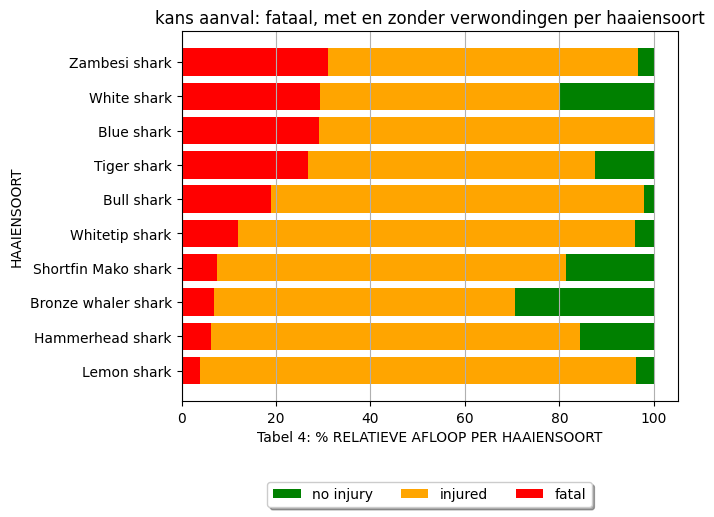

In [8]:
#@title <--Klik voor tabel 4 { run: "auto", vertical-output: true }
# Nieuw dataframe voor tabel 4 met alleen Unprovoked incidenten
df_sharks_q1_tbl4 = df_sharks_q1[df_sharks_q1['Type']=='Unprovoked']

# een lijst van haaiensoorten met minimaal 15 unprovoked aanvallen
shark_list_15 = df_sharks_q1_tbl4['shark_type'].value_counts() > 15 

# een functie die alleen haaien retourneert die in de lijst van 15 aanvallen staan
def shark_filter(shark_type):
  return shark_list_15[shark_type]

# laat de functie over kolom shark_type gaan en creëer een boolean list
mask_shark_list=df_sharks_q1_tbl4['shark_type'].transform(shark_filter)

# voor de mask uit op df_sharks_q1_tbl4
df_sharks_q1_tbl4 = df_sharks_q1_tbl4[mask_shark_list]

# bereken gemiddeldes per soort
df_sharks_q1_tbl4 = df_sharks_q1_tbl4.groupby('shark_type').mean().sort_values(by=['Fatal','injured'],ascending=False)

# verander decimalen in percentages
def convert_perc(col):
  return round(col*100,2)

# voer mask convert_perc op alle velden in df_sharks_q1_tb4
df_sharks_q1_tbl4 = df_sharks_q1_tbl4.transform(convert_perc)

# X,Y AS
X_fatal = df_sharks_q1_tbl4['Fatal'][0:10] # eerste vijftien soorten
X_injured = df_sharks_q1_tbl4['injured'][0:10]
X_no_inj =  df_sharks_q1_tbl4['no_injury'][0:10]
Y = df_sharks_q1_tbl4.index[0:10]

#plt.rcdefaults()
fig, ax = plt.subplots()

bar1 = ax.barh(Y, X_fatal+X_injured+X_no_inj, xerr=error, color='green',label='no injury')
bar2 = ax.barh(Y, X_fatal+X_injured, xerr=error, color='orange', label='injured')
bar2 = ax.barh(Y, X_fatal, xerr=error, color='red', label='fatal')


# Example data
error = 0

# drawing chart

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Tabel 4: % RELATIEVE AFLOOP PER HAAIENSOORT')
ax.set_ylabel('HAAIENSOORT')
ax.set_title('kans aanval: fataal, met en zonder verwondingen per haaiensoort')
ax.xaxis.grid()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
plt.show()

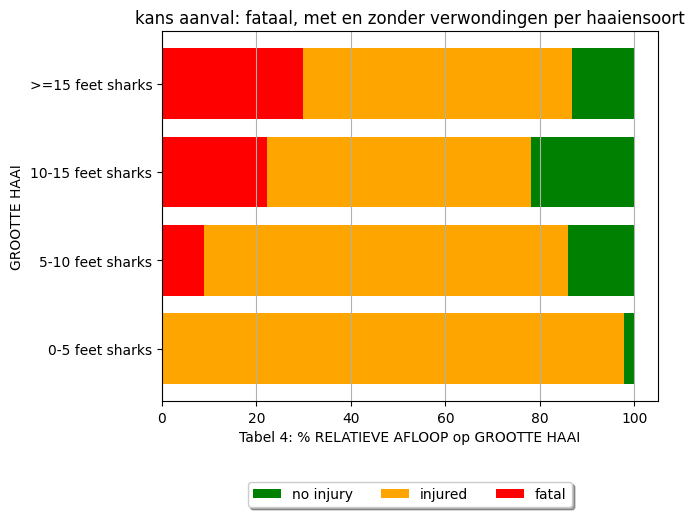

In [9]:
#@title <--Klik voor tabel 5 { run: "auto", vertical-output: true }
# Nieuw dataframe voor tabel 5 met alleen Unprovoked incidenten
df_sharks_q1_tbl5 = df_sharks_q1.loc[df_sharks_q1['Type']=='Unprovoked',:]

# verwijderen kolom shark_type ( inplace True gaf een copywarning)
df_sharks_q1_tbl5 = df_sharks_q1_tbl5.drop(columns=['shark_type'])

# verwijderen NAN's in kolom shark_size
df_sharks_q1_tbl5 = df_sharks_q1_tbl5.dropna(subset={'shark_size'})

# bereken gemiddelde aandeel per soort
df_sharks_q1_tbl5 = df_sharks_q1_tbl5.groupby('shark_size').mean().sort_values(by=['Fatal','injured'],ascending=False)

# verander decimalen in percentages
def convert_perc(col):
  return round(col*100,2)

# voer mask convert_perc op alle velden in df_sharks_q1_tb4
df_sharks_q1_tbl5 = df_sharks_q1_tbl5.transform(convert_perc)

# X,Y AS
X_fatal = df_sharks_q1_tbl5['Fatal'][0:10] # eerste vijftien soorten
X_injured = df_sharks_q1_tbl5['injured'][0:10]
X_no_inj =  df_sharks_q1_tbl5['no_injury'][0:10]
Y = df_sharks_q1_tbl5.index[0:10]

#plt.rcdefaults()
fig, ax = plt.subplots()

bar1 = ax.barh(Y, X_fatal+X_injured+X_no_inj, xerr=error, color='green', label='no injury')
bar2 = ax.barh(Y, X_fatal+X_injured, xerr=error, color='orange', label='injured')
bar2 = ax.barh(Y, X_fatal, xerr=error, color='red', label='fatal')


# Example data
error = 0

# drawing chart

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Tabel 4: % RELATIEVE AFLOOP op GROOTTE HAAI')
ax.set_ylabel('GROOTTE HAAI')
ax.set_title('kans aanval: fataal, met en zonder verwondingen per haaiensoort')
ax.xaxis.grid()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3,)
plt.show()


# **CONCLUSIE: Wat zijn voor mensen de meest gevaarlijke haaiensoorten?**
---

De witte haai is voor de mens de gevaarlijkste haai. Weliswaar staat de witte haai in tabel 4 met een klein verschil op de tweede plaats, maar gezien de grote aantallen aanvallen hebben we het meest te duchten voor de witte haai.
De nummer 1 uit tabel 4, de Zambesi Haai, kom je niet snel tegen tijdens het zwemmen of surfen. Als je hem wel tegenkomt, adviseer ik hard te zwemmen aangezien deze haai nauwelijks iemand ongeschonden laat. Verder is het oppassen voor de: Blue Shark, Tiger Shark en Bull Shark.

Tabel 5 laat zien dat er een verband is tussen de grootte en het percentage dodelijk aanvallen. Er is tevens een verband te zien tussen de grootte en de kans op een afloop zonder verwondingen. Het lijkt erop hoe kleiner de haai hoe agressiever en hoe groter des te dodelijker de haai is.


#**VRAAG 2) hebben kinderen meer kans door haaien aangevallen te worden?**
---
 
Bij het beantwoorden van deze vraag is belangrijk welke leeftijden onder "kinderen" wordt verstaan. Is het een persoon onder 18 jaar? Of spreekt men van "kinderen" in de leeftijdsgroep van 0 tot 12 jaar en van "teenagers" in de leeftijdsgroep van 12 t/m 17 jaar.

Meerderen factoren kunnen van invloed zijn op de vraag of kinderen een grotere kans hebben om te worden aangevallen. Het kan hierbij gaan om het gedrag, achteloosheid, de zwemvaardigheid of postuur (grootte) van het kind. Externe factoren zoals bijvoorbeeld de verhoudingsgewijs meer aanwezige kinderen, regioverschillen en weersomstandigheden zouden juist uitgesloten moeten worden. 

Uit de Shark Attack File blijkt dat bij 41% van de de aanvallen geen leeftijd bekend is. Dit kan een scheef beeld geven, maar voor wat betreft de aanvallen waarbij de leeftijd wel bekend is, is die verspreid tussen 1 en 87 jaar. De gemiddelde leeftijd van alle incidenten is 27,51 jaar. De mediaan is 24 jaar. De gemiddelde leeftijd bij alle "niet uitgelokte" is met 27 jaar en een mediaan van 23 jaar nagenoeg onveranderd. Zie verder tabel 6 hieronder. 




In [10]:
#@title <--Klik voor tabel 6 { run: "auto", vertical-output: true }
# maak voor vraag 2 een tabel en verwijder rijen met lege waarden in kolom Age
df_sharks_q2 = df_sharks.dropna(subset={'Age'})

# maak aparte tabel voor vraag 2 met alleen unprovoked incidenten
df_sharks_q2_unprov = df_sharks_q2.loc[df_sharks_q2['Type']=='Unprovoked']

# verwijder onnodige kolommen
df_sharks_q2_unprov = df_sharks_q2_unprov.drop(columns=['Type','Activity','Injury','injured','no_injury','Fatal','Species','shark_type','shark_size'])
df_sharks_q2 = df_sharks_q2.drop(columns=['Type','Activity','Injury','injured','no_injury','Fatal','Species','shark_type','shark_size'])

perc_no_age = round((len(df_sharks.loc[df_sharks['Age'].isnull()==True]) / len(df_sharks.index)) *100,2)
min_age = df_sharks_q2['Age'].min()
max_age = df_sharks_q2['Age'].max()
average_age = round(df_sharks_q2['Age'].mean(),2)
average_age_unprov = round(df_sharks_q2_unprov['Age'].mean(),2)
mediaan_age = df_sharks_q2['Age'].median()
mediaan_age_unprov = df_sharks_q2_unprov['Age'].median()

print('TABEL 6')
print('----------------------------------------------------------')
print(f'Percentage incidenten zonder leeftijd=\t\t{perc_no_age}%\n')
print(f'jongste persoon\t\t\t\t\toudste persoon\n{min_age} jaar\t\t\t\t\t{max_age} jaar\n')
print(f'Gemiddelde leeftijd, alle aanvallen=\t\t{average_age} jaar')
print(f'Mediaan leeftijden, alle aanvallen=\t\t{mediaan_age} jaar')
print(f'Gemiddelde leeftijd, niet uitgelokte aanvallen=\t{average_age_unprov} jaar')
print(f'Mediaan leeftijd, niet uitgelokte aanvallen=\t{mediaan_age_unprov} jaar')


TABEL 6
----------------------------------------------------------
Percentage incidenten zonder leeftijd=		41.08%

jongste persoon					oudste persoon
1.0 jaar					87.0 jaar

Gemiddelde leeftijd, alle aanvallen=		27.5 jaar
Mediaan leeftijden, alle aanvallen=		24.0 jaar
Gemiddelde leeftijd, niet uitgelokte aanvallen=	27.02 jaar
Mediaan leeftijd, niet uitgelokte aanvallen=	23.0 jaar


Uit tabel 6 blijkt dat de mediaan lager is dan het gemiddelde, wat betekent dat bij 50% van alle incidenten (uitgelokt en niet-uitgelokt) de persoon jonger dan 24 jaar is.

Hieronder in tabel 7 een Boxplot Grafiek van alleen "niet uitgelokte" aanvallen dat laat zien dat jongeren vaker betrokken zijn bij een haaienaanval. Maar liefst 25% van alle "niet uitgelokte" aanvallen gebeurd bij personen in de leeftijd van 17 tot 23 jaar.

TABEL 7
Boxplot alle leeftijden en per leeftijdsgroep


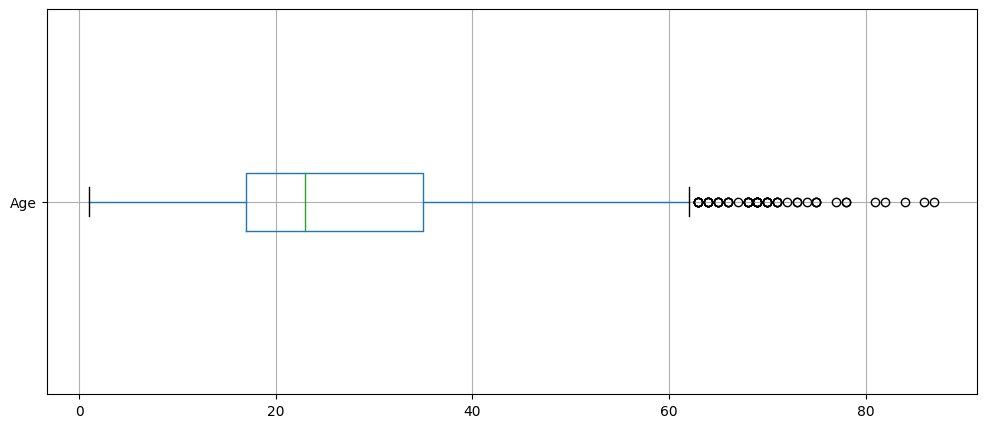

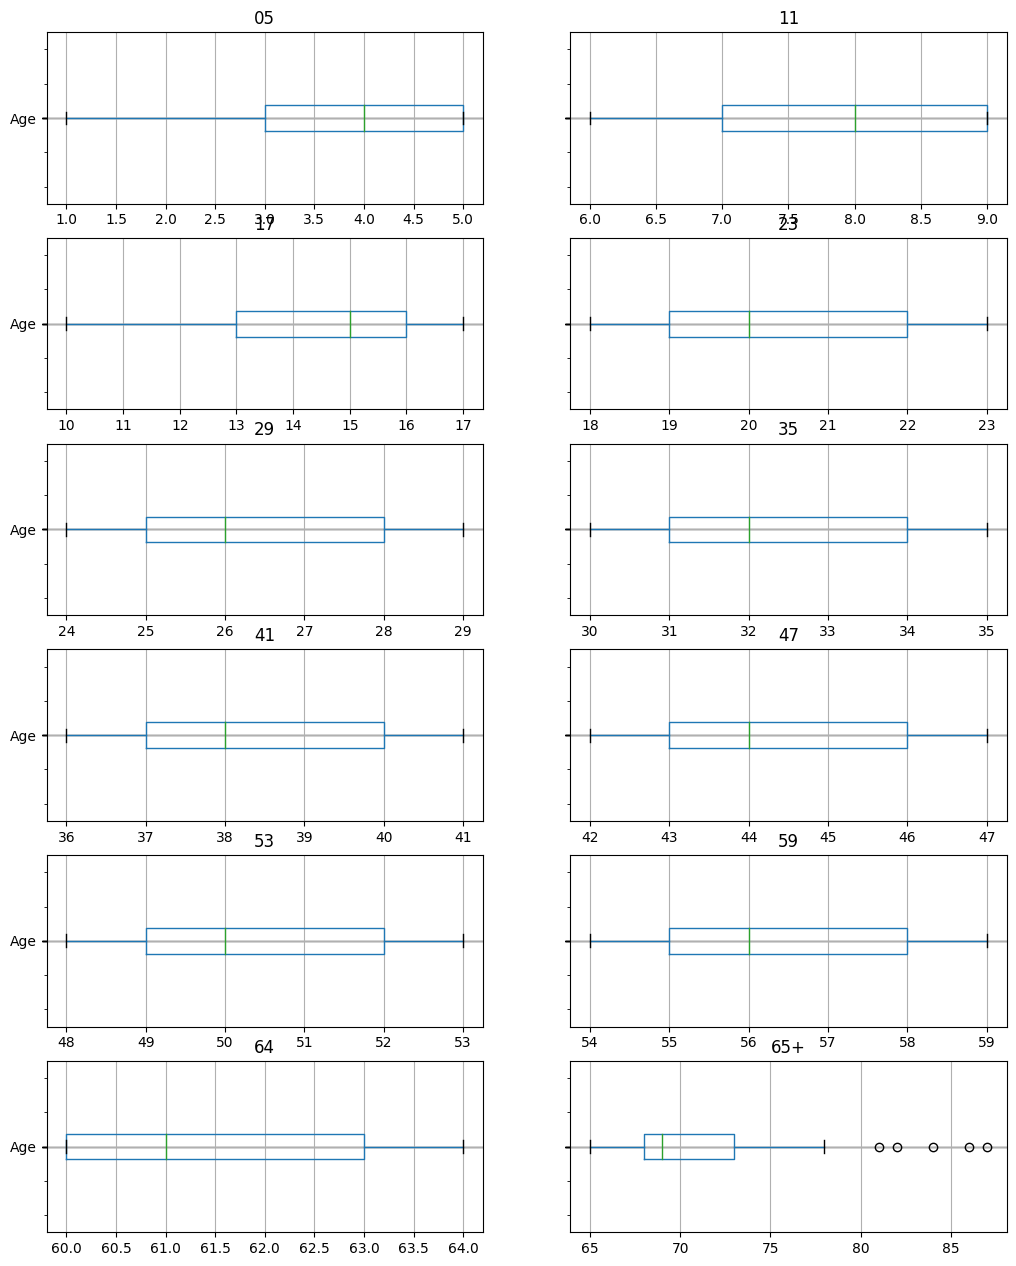

In [11]:
#@title <--Klik voor tabel 7 { run: "auto", vertical-output: true }
print('TABEL 7\nBoxplot alle leeftijden en per leeftijdsgroep')
tbl_boxplot = df_sharks_q2_unprov.boxplot(vert=False,figsize=(12,5))
tbl_boxplot = df_sharks_q2_unprov.groupby('age_grp').boxplot(vert=False, figsize=(12,16), layout=(6,2))

De grafieken 8 en 9 hieronder zijn grafieken met de percentages aanvallen per leeftijdsgroep. De leeftijden zijn steeds met 6 jaren gegroepeerd.

De meeste incidenten, maar liefst 25%, gebeuren in de leeftijd van 12 tot en met 17 jaar. Dus het lijkt erop, zover het kinderen tussen 12 en 17 betreft, kinderen meer kans hebben aangevallen te worden.


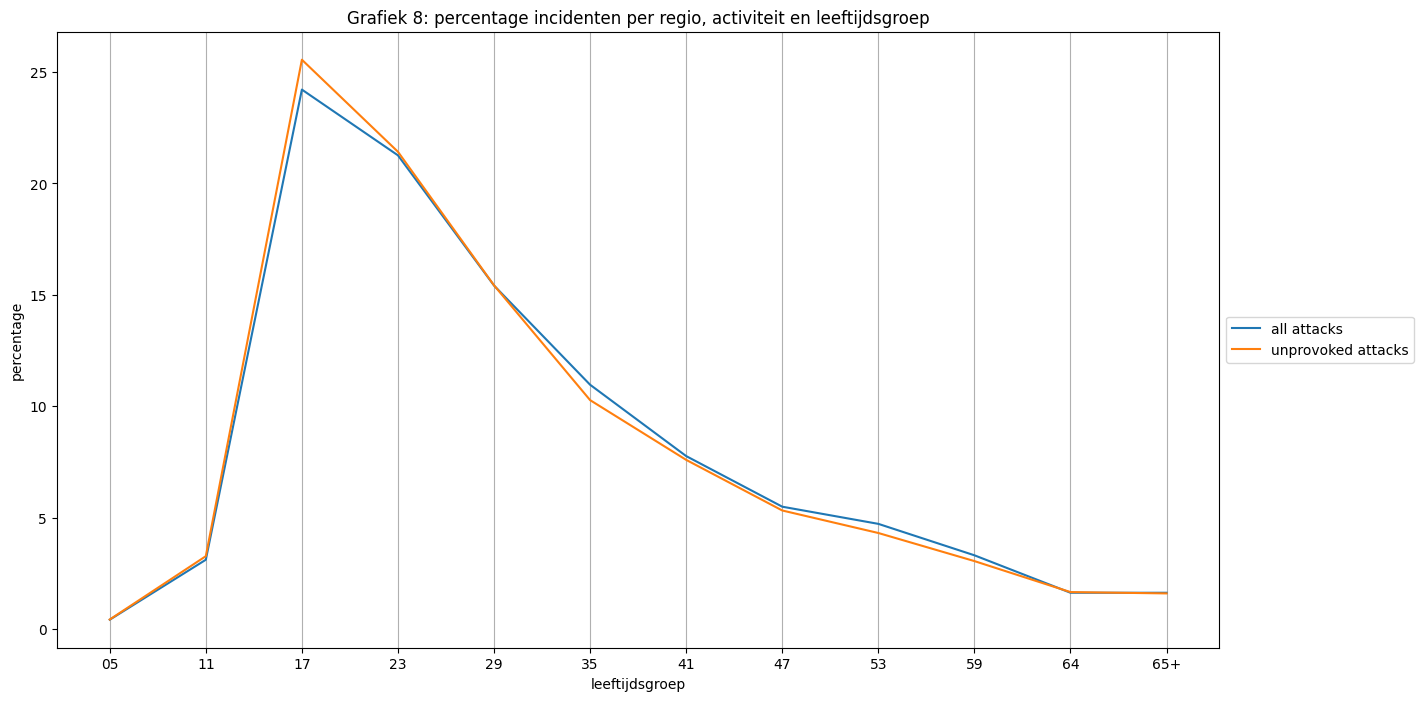

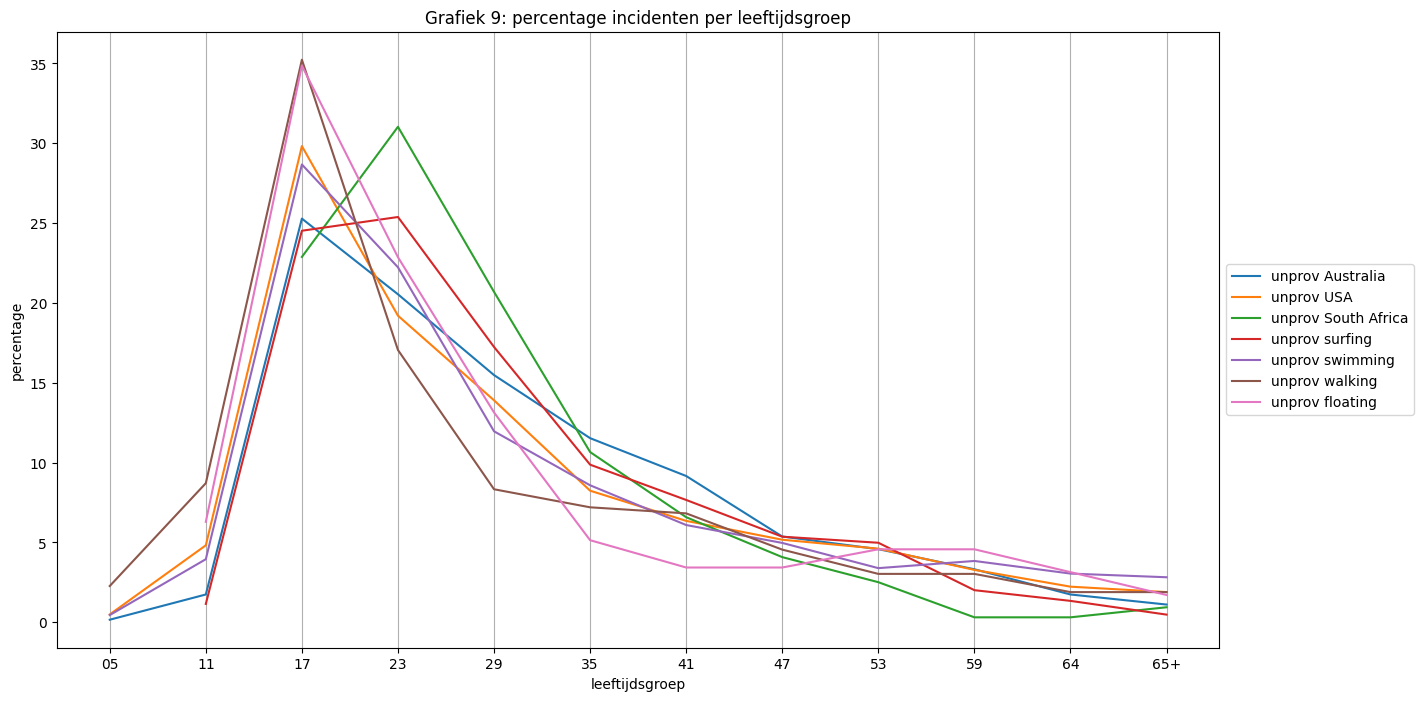

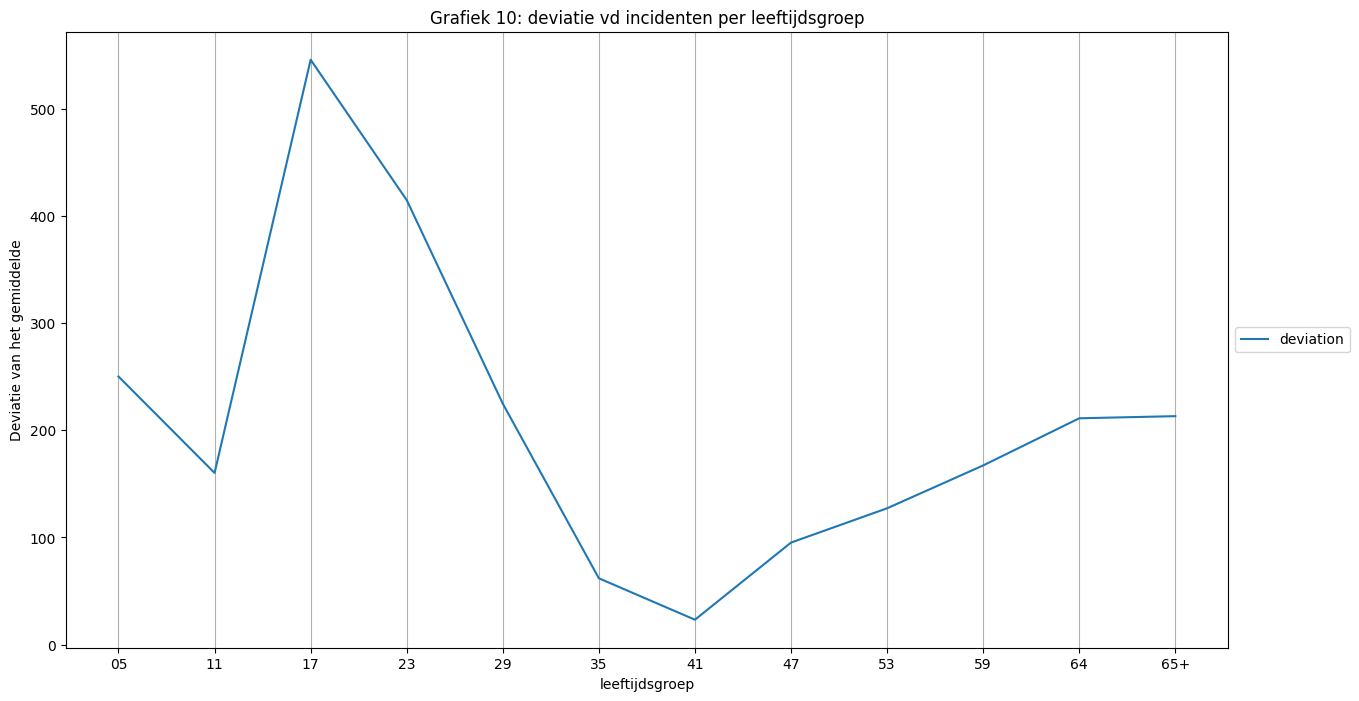

In [40]:
#@title <--Klik voor grafiek 8, 9 en 10 { run: "auto", vertical-output: true }
# functie die percentage incidenten t.o.v. het totaal berekent
def attacks_perc(col):
  som = col.sum()
  return round(((col / som) * 100),2)

# maak een functie voor het berekenen van de deviatie
def deviation_from_average(col):
  average = col.mean()
  return abs(col - average)


# deze dict bevat te berekenen variablen voor tabel 8
age_dict1={
'all attacks'         : df_sharks_q2.groupby('age_grp').count().transform(attacks_perc),
'unprovoked attacks'  : df_sharks_q2_unprov.groupby('age_grp').count().transform(attacks_perc),
}

# deze dict bevat te berekenen variablen voor tabel 9
age_dict2={
'unprov Australia'    : df_sharks_q2_unprov.loc[df_sharks_q2_unprov['Country']=='AUSTRALIA'].groupby(['age_grp']).count().transform(attacks_perc),
'unprov USA'          : df_sharks_q2_unprov.loc[df_sharks_q2_unprov['Country']=='USA'].groupby(['age_grp']).count().transform(attacks_perc),
'unprov South Africa' : df_sharks_q2_unprov.loc[df_sharks_q2_unprov['Country']=='SOUTH AFRICA'].groupby(['age_grp']).count().transform(attacks_perc),
'unprov surfing'      : df_sharks_q2_unprov.loc[df_sharks_q2_unprov['activity_grp']=='surfing'].groupby(['age_grp']).count().transform(attacks_perc),
'unprov swimming'     : df_sharks_q2_unprov.loc[df_sharks_q2_unprov['activity_grp']=='swimming'].groupby(['age_grp']).count().transform(attacks_perc),
'unprov walking'      : df_sharks_q2_unprov.loc[df_sharks_q2_unprov['activity_grp']=='walking'].groupby(['age_grp']).count().transform(attacks_perc),
'unprov floating'     : df_sharks_q2_unprov.loc[df_sharks_q2_unprov['activity_grp']=='floating'].groupby(['age_grp']).count().transform(attacks_perc)
}

# deze dict bevat te berekenen variablen voor tabel 10
age_dict3={
'deviation'           : df_sharks_q2_unprov.groupby('age_grp').count().transform(deviation_from_average)    
}

# TABEL 8
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

for tabelname in (age_dict1):
  tabel = age_dict1[tabelname]
  x = tabel.index
  y = tabel.loc[:,'Age']
  ax.plot(x,y,label=tabelname)

ax.set_xlabel('leeftijdsgroep')
ax.set_ylabel('percentage')
ax.set_title('Grafiek 8: percentage incidenten per regio, activiteit en leeftijdsgroep')
ax.xaxis.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# TABEL 9
fig,ax2 = plt.subplots()
fig.set_size_inches(15, 8)

for tabelname in (age_dict2):
  tabel = age_dict2[tabelname]
  x = tabel.index
  y = tabel.loc[:,'Age']
  ax2.plot(x,y,label=tabelname)

ax2.set_xlabel('leeftijdsgroep')
ax2.set_ylabel('percentage')
ax2.set_title('Grafiek 9: percentage incidenten per leeftijdsgroep')
ax2.xaxis.grid()
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# TABEL 10
fig,ax2 = plt.subplots()
fig.set_size_inches(15, 8)

for tabelname in (age_dict3):
  tabel = age_dict3[tabelname]
  x = tabel.index
  y = tabel.loc[:,'Age']
  ax2.plot(x,y,label=tabelname)

ax2.set_xlabel('leeftijdsgroep')
ax2.set_ylabel('Deviatie van het gemiddelde')
ax2.set_title('Grafiek 10: deviatie vd incidenten per leeftijdsgroep')
ax2.xaxis.grid()
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

***Toelichting grafiek 9:***
Door de relatieve verhoudingen ook per regio en activiteit met elkaar te vergelijken, komt men achter of de regioverschillen en activiteiten invloed hebben op het aantal incidenten per leeftijdsgroep. Zoals uit grafiek 9 naar voren komt, blijft de leeftijdsgroep van 12 tot en met 17, ondanks andere regio en activiteit, steeds de groep waar relatief de meeste aanvallen gebeuren.

***Toelichting grafiek 10:***
In grafiek zien we een dalende deviatie onder kinderen van 6 tot en met 11 jaar wat inhoudt dat de het aantal incidenten juiste afneemt t.o.v. het gemiddelde.

#**CONCLUSIE: hebben kinderen meer kans door haaien aangevallen te worden?**
---

Slechts bij 40% van alle incidenten is de leeftijd bekend. Het is niet zeker dat de groep waarvan de leeftijd bekend is, 100% representatief is voor alle incidenten. Uit de tabellen blijkt dat ongeacht de regio of activiteit de leeftijd een grote invloed heeft op het verloop van aantal incidenten. Kinderen van 5 t/m 11 jaar hebben niet meer kans op een haaienaanval. Daarentegen geldt er wel een veel grotere kans op een haaienaanval voor de groep kinderen van 12 t/m 17 jaar. Vermoedelijk dat achteloosheid een belangrijke reden kan zijn voor deze uitkomst.

#***VRAAG 3) zijn aanvallen van haaien die worden uitgelokt meer of minder gevaarlijk?***
---

De onderzoekers die de Shark Attack File bijhouden beslissen of een aanval uitgelokt of niet-uitgelokt is. Aangezien de organisatie "pro shark" is, kan hier een bias zijn ontstaan. Wat de uitkomst ook zal zijn, zal het om die reden aanvechtbaar zijn. 

Om deze vraag te beantwoorden, moet je weten wat een gevaarlijke aanval is? Wat weegt zwaarder een fatale aanval of een aanval zonder verwondingen? Bij vraag 1 liet ik de fatale aanval zwaarder wegen. Dit zal ik nu weer doen.

Om het antwoord te vinden, onderzocht ik eerst het aandeel aanvallen zonder verwondingen, met verwondingen en met fatale afloop onder de uitgelokte incidententen en vergeleek die met de niet uitgelokte aanvallen. Zie de pie chart in figuur 11 hieronder.

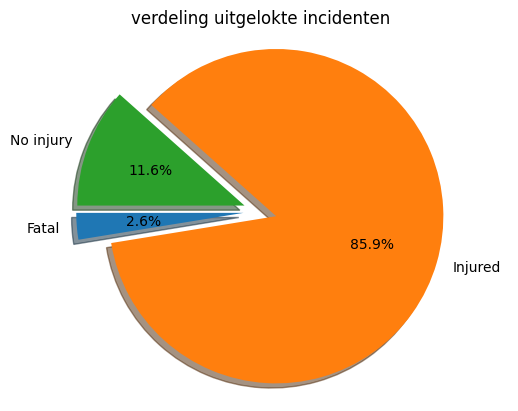

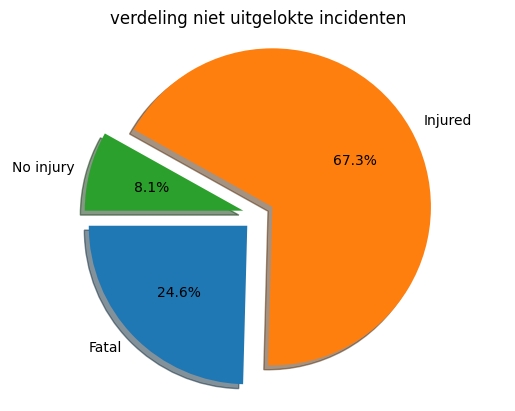

In [13]:
#@title <--Klik voor figuur 11 (Pie Chart) { run: "auto", vertical-output: true }
# dataframe voor het beantwoorden van vraag 3 en verwijder lege waarden in kolom injury
df_sharks_q3 = df_sharks.dropna(subset={'Injury'})

# maak twee aparte tabellen voor vraag 3 met alleen provoked en unprovoked incidenten
df_sharks_q3_unprov = df_sharks_q3.loc[df_sharks_q3['Type']=='Unprovoked']
df_sharks_q3_prov = df_sharks_q3.loc[df_sharks_q3['Type']=='Provoked']

# verwijder onnodige kolommen
df_sharks_q3_unprov = df_sharks_q3_unprov.drop(columns=['Country','Activity','Age','Injury','injury_grp', 'Species','age_grp', 'shark_type','shark_size'])
df_sharks_q3_prov = df_sharks_q3_prov.drop(columns=['Country','Activity','Age','Injury','injury_grp', 'Species','age_grp', 'shark_type','shark_size'])

# maak twee lijsten met aandeel uitgelokte en niet uitgelokte aanvallen
# mean() berekend in dit geval het percentage per kolom. Zonder groupby gaf pandas een error
df_sharks_q3_perc_unprov = df_sharks_q3_unprov.groupby('Type').mean()
df_sharks_q3_perc_prov = df_sharks_q3_prov.groupby('Type').mean()

# maak een dictioary met de variabelen voor de for-loops in mijn pie plot. Float voorkomt deprecated foutmelding matplotlib
pie_dict={
    'verdeling uitgelokte incidenten'        : {
                                                'Fatal'     : float(round(df_sharks_q3_perc_prov['Fatal']*100,2)),
                                                'Injured'   : float(round(df_sharks_q3_perc_prov['injured']*100,2)), 
                                                'No injury' : float(round(df_sharks_q3_perc_prov['no_injury']*100,2))
                                          },
    'verdeling niet uitgelokte incidenten'   : {
                                                'Fatal'     : float(round(df_sharks_q3_perc_unprov['Fatal']*100,2)),
                                                'Injured'   : float(round(df_sharks_q3_perc_unprov['injured']*100,2)), 
                                                'No injury' : float(round(df_sharks_q3_perc_unprov['no_injury']*100,2))
                                          }
}


# plot pie plots van de gegevens in pie_dict
for taart in pie_dict:
  labels = pie_dict[taart].keys()
  data = pie_dict[taart].values()
  fig, ax = plt.subplots()
  explode=[]
  for i in range(len(pie_dict[taart])):
    explode.append(0.1)
  ax.pie(data, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=180)
  ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  ax.set_title(taart)
  plt.show()





In de Pie chart van figuur 11 verschilt het aandeel "aanval zonder verwondingen" niet veel tussen uitgelokte en niet-uitgelokte aanvallen. Het verschil is slechts 3,5%. Daarentegen zijn er wel veel meer (22%) dodelijke aanvallen bij niet uitgelokte aanvallen. 

Niet zo verwonderlijk omdat de persoon die een aanval uitlokt al voorbereid is op een tegenaanval van de haai en maatregelen heeft genomen om verwondingen te reduceren. Ook is het aandeel vissersboten groter onder de uitgelokte aanvallen en daardoor kan het het aantal fatale aanvallen lager uitvallen. 

Als door tegenmaatregelen het aandeel dodelijke aanvallen is verminderd, kun je op basis van de factor 'fatale afloop" geen uitspraak meer doen of een haai gevaarlijker is als het wordt uitgelokt.

Daarom wil ik de uitgelokte en niet-uitgelokte aanvallen vergelijken op dezelfde activiteit. Vergelijken we de twee tabellen dan zien we bij de niet-uitgelokte aanvallen dat de aanvallen zijn verspreid over diverse activiteiten. Maar in de tabel met uitgelokte aanvallen zien we met name aanvallen bij activiteit "Fishing". Het aantal uitgelokte aanvallen bij de andere activiteiten is te laag om goed met de activiteiten van niet-uitgelokte aanvallen te vergelijken. Zie tabel 12 en 13 hieronder.


In [14]:
#@title <--Klik voor tabel 12 { run: "auto", vertical-output: true }
# bereken aantal aanvallen per activiteit uitgelokte activiteiten
df_sharks_q3_tbl12 = df_sharks_q3_prov.groupby('activity_grp').count().sort_values(by=['activity_grp','Fatal','injured'],ascending=False)

# bereken aantal aanvallen per activiteit niet-uitgelokte activiteiten
df_sharks_q3_tbl13 = df_sharks_q3_unprov.groupby('activity_grp').count().sort_values(by=['activity_grp','Fatal','injured'],ascending=False)

# verwijder een paar rijen die niet in beide tabellen zitten
df_sharks_q3_tbl12 = df_sharks_q3_tbl12.drop('other') 
df_sharks_q3_tbl13 = df_sharks_q3_tbl13.drop(['murdering','other']) 

print('TABEL 12: Aantal uitgelokte aanvallen per activiteit\n')
display(df_sharks_q3_tbl12['Type'])
print('\n\nTABEL 13: Aantal niet uitgelokte aanvallen per activiteit')
display(df_sharks_q3_tbl13['Type'])



TABEL 12: Aantal uitgelokte aanvallen per activiteit



activity_grp
walking      16
swimming     18
surfing      24
shark        80
sailing       2
rowing        4
playing       3
floating      3
fishing     383
diving       42
Name: Type, dtype: int64



TABEL 13: Aantal niet uitgelokte aanvallen per activiteit


activity_grp
walking      330
swimming    1376
surfing     1315
shark         19
sailing       41
rowing        26
playing      157
floating     207
fishing      672
diving       395
Name: Type, dtype: int64

De enige mogelijkheid om te achterhalen of een haai meer of minder gevaarlijk is als die wordt uitgelokt, is door te vergelijken in dezelfde activiteit. Personen die met dezelfde activiteit bezig zijn, hebben gelijke kansen om zich te verdedigen tegen een haaienaanval. Alleen in de activiteit "Fishing" is er voldoende data om representatief te kunnen vergelijken. 

Hieronder weer een staaf diagram met het percentage fatale en andere aanvallen per activiteit. Behalve de meest representatieve activiteit "Fishing", heb ik ook de activiteiten in de tabel opgenomen waarbij na "Fishing" de meeste aanvallen gebeuren. 

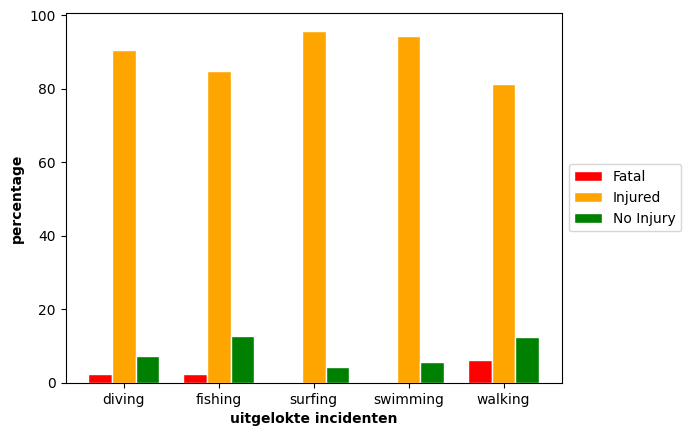

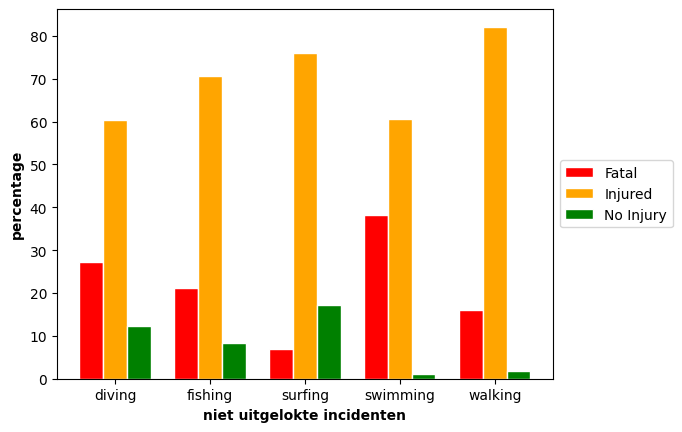

In [15]:
#@title <--Klik voor tabellen 14 en 15 { run: "auto", vertical-output: true }
# te onderzoeken activiteiten
act_research = ['fishing', 'diving', 'surfing', 'swimming','walking']

# mask  
activity_mask_prov = df_sharks_q3_prov['activity_grp'].isin(act_research) == True
activity_mask_unprov = df_sharks_q3_unprov['activity_grp'].isin(act_research) == True

# pas de mask toe
df_sharks_q3_prov = df_sharks_q3_prov.loc[activity_mask_prov,:]
df_sharks_q3_unprov = df_sharks_q3_unprov.loc[activity_mask_unprov,:]

# bereken percentage per activiteit uitgelokte activiteiten
df_sharks_q3_tbl14 = df_sharks_q3_prov.groupby('activity_grp').mean().sort_values(by=['activity_grp','Fatal','injured'],ascending=True)

# bereken percentage per activiteit niet-uitgelokte activiteiten
df_sharks_q3_tbl15 = df_sharks_q3_unprov.groupby('activity_grp').mean().sort_values(by=['activity_grp','Fatal','injured'],ascending=True)

# verander decimalen in percentages
def convert_perc(col):
  return round(col*100,2)

# zet waardes in de tabellen om in afgeronde percentage
df_sharks_q3_tbl14 = df_sharks_q3_tbl14.transform(convert_perc)
df_sharks_q3_tbl15 = df_sharks_q3_tbl15.transform(convert_perc)

# TABEL 14 Bar Chart uitgelokte aanvallen

# set width of bars
barWidth = 0.25
 
# set heights of bars
bar1_fatal = df_sharks_q3_tbl14['Fatal']
bar2_injured = df_sharks_q3_tbl14['injured']
bar3_no_injury = df_sharks_q3_tbl14['no_injury']
 
# Set position of bar on X axis
r1 = np.arange(len(bar1_fatal))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bar1_fatal, color='red', width=barWidth, edgecolor='white', label='Fatal')
plt.bar(r2, bar2_injured, color='orange', width=barWidth, edgecolor='white', label='Injured')
plt.bar(r3, bar3_no_injury, color='green', width=barWidth, edgecolor='white', label='No Injury')
 
# Add xticks on the middle of the group bars
plt.xlabel('uitgelokte incidenten', fontweight='bold')
plt.ylabel('percentage', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bar1_fatal))], df_sharks_q3_tbl14.index)
 
# Create legend & Show graphic
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# TABEL 15 Bar Chart niet-uitgelokte aanvallen

# set width of bars
barWidth = 0.25
 
# set heights of bars
bar1_fatal = df_sharks_q3_tbl15['Fatal']
bar2_injured = df_sharks_q3_tbl15['injured']
bar3_no_injury = df_sharks_q3_tbl15['no_injury']
 
# Set position of bar on X axis
r1 = np.arange(len(bar1_fatal))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bar1_fatal, color='red', width=barWidth, edgecolor='white', label='Fatal')
plt.bar(r2, bar2_injured, color='orange', width=barWidth, edgecolor='white', label='Injured')
plt.bar(r3, bar3_no_injury, color='green', width=barWidth, edgecolor='white', label='No Injury')
 
# Add xticks on the middle of the group bars
plt.xlabel('niet uitgelokte incidenten', fontweight='bold')
plt.ylabel('percentage', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bar1_fatal))], df_sharks_q3_tbl15.index)
 
# Create legend & Show graphic
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# **CONCLUSIE: zijn aanvallen van haaien die worden uitgelokt meer of minder gevaarlijk?**
---

Ongeacht de activiteit is in een oogopslag te zien dat het percentage fatale aanvallen hoger is in de tabel met niet uitgelokte aanvallen.

Tegen de verwachting in, blijkt dus dat haaien gevaarlijker zijn als ze niet zijn geprovoceerd.

 
# **VRAAG 4) Hebben bepaalde activiteiten meer kans op een aanval van een haai?**
---

Uit de tabellen 12 en 13 van vraag 3 is te zien dat bepaalde activiteiten vaker gebeuren, maar dat dit niet consistent bij elke type aanval het geval is. Zo blijkt dat 'zwemmen' bij de niet-uitgelokte aanvallen de meeste kans heeft op een haaienaanval, maar dat bij de uitgelokte aanvallen 'zwemmen' in de middenmoot zit.

Als sommige activiteiten meer kans zouden hebben op een aanval dan moet dat ongeacht het type aanval of bijvoorbeeld regio zijn. 

Hieronder zie je 3 grafieken van het aantal haaienaanvallen per activiteit en per land. Acht landen met de meeste haaienaanvallen zijn in de grafiek opgenomen. 

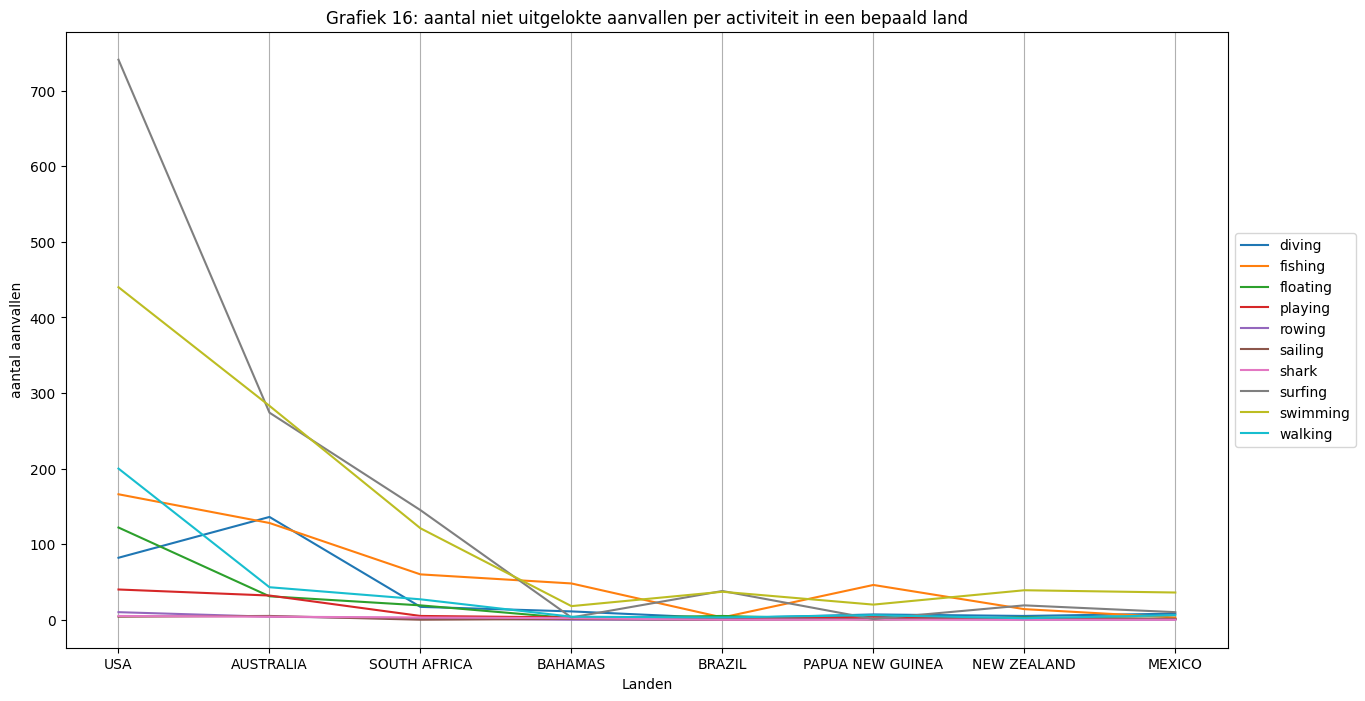

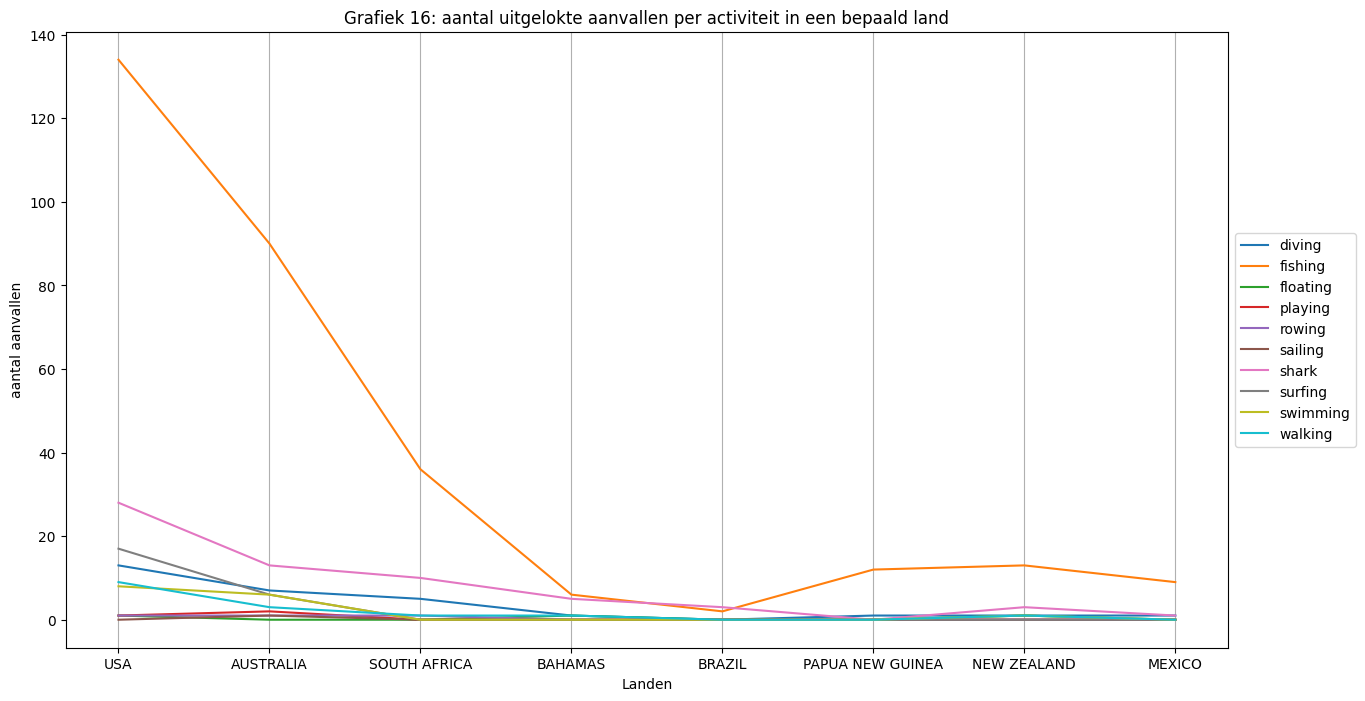

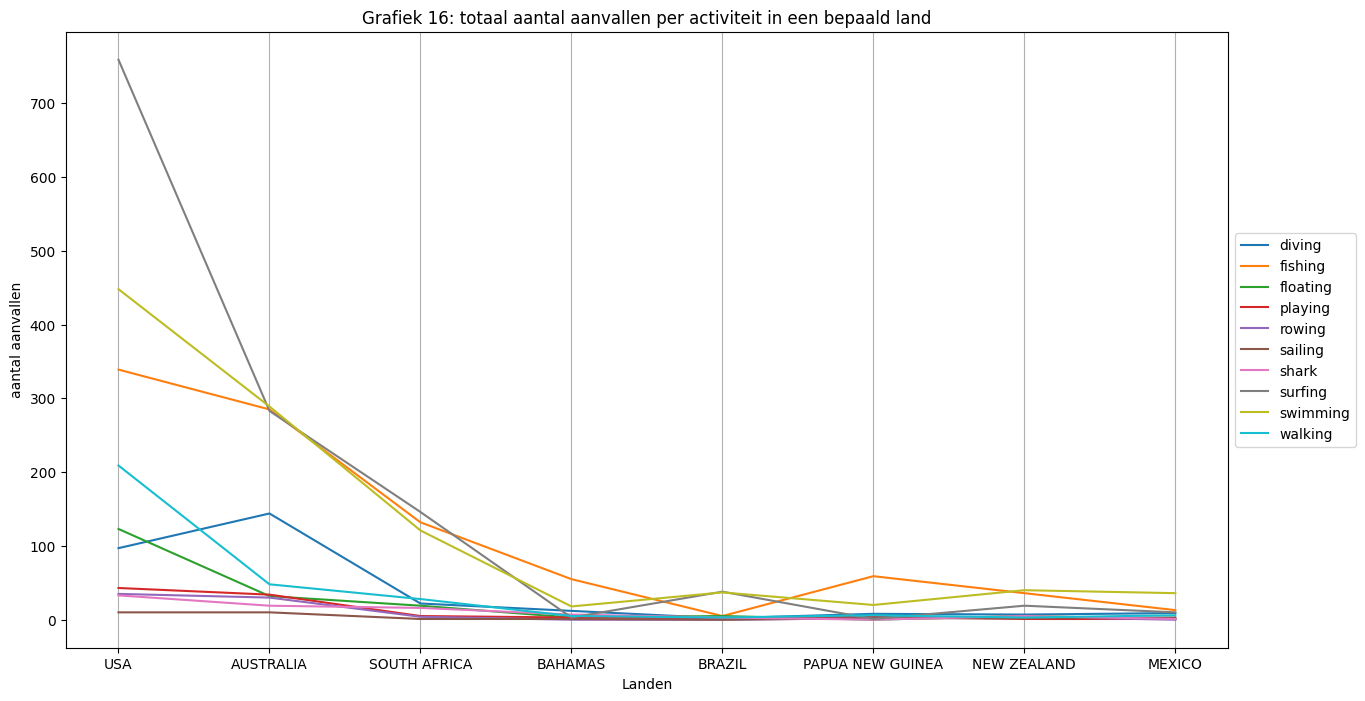

In [16]:
#@title <--Klik hier voor grafieken 16, 17 en 18 { run: "auto", vertical-output: true }
# verwijder kolommen df_sharks voor vraag 4 
df_sharks_q4 = df_sharks.drop(columns=['Age', 'Injury', 'Fatal', 'Species', 'injury_grp', 'injured', 'no_injury', 'Activity', 'age_grp', 'shark_type', 'shark_size'])

# verwijder rijen met NAN waarden in kolom activity_grp
df_sharks_q4 = df_sharks_q4.dropna(subset={'activity_grp'})

# maak een lijst met landen in de top 8 met de meest niet uitgelokte aanvallen
df_sharks_topregions = (df_sharks_q4.loc[df_sharks_q4['Type']=='Unprovoked'].groupby('Country').count().sort_values(by=['Type'],ascending=False)).iloc[0:8,:].index

# **** maak 3 tabellen voor 3 grafieken *****
# mask unprovoked en in top 8 lijst
mask_country_unprov = (df_sharks_q4['Type']=='Unprovoked') & (df_sharks_q4['Country'].isin(df_sharks_topregions))

# mask provoked en in top 8 lijst
mask_country_prov = (df_sharks_q4['Type']=='Provoked') & (df_sharks_q4['Country'].isin(df_sharks_topregions))

# mask alle aanvallen en in top 8 lijst
mask_country_all = df_sharks_q4['Country'].isin(df_sharks_topregions)


# voer de mask uit, en maak 3 nieuw gesorteerde tabel
df_sharks_q4_tbl16 = df_sharks_q4.loc[mask_country_unprov].groupby(['activity_grp', 'Country']).count().sort_values(by=['activity_grp', 'Country'],ascending=True)
df_sharks_q4_tbl17 = df_sharks_q4.loc[mask_country_prov].groupby(['activity_grp', 'Country']).count().sort_values(by=['activity_grp', 'Country'],ascending=True)
df_sharks_q4_tbl18 = df_sharks_q4.loc[mask_country_all].groupby(['activity_grp', 'Country']).count().sort_values(by=['activity_grp', 'Country'],ascending=True)

# verwijder activiteit 'other' uit de tabel
df_sharks_q4_tbl16 = df_sharks_q4_tbl16.drop('other')
df_sharks_q4_tbl17 = df_sharks_q4_tbl17.drop('other')
df_sharks_q4_tbl18 = df_sharks_q4_tbl18.drop('other')


# maak een lijst met de activiteiten die in tbl16 zijn. Dezelfde lijst gebruik ik ook voor de andere grafieken 17 en 18.
df_sharks_act = df_sharks_q4_tbl16.index.get_level_values(0).unique()

# verander multiindex level 1 zoals de lijst landen in df_sharks_topregions
df_sharks_q4_tbl16 = df_sharks_q4_tbl16.reindex(pd.MultiIndex.from_product([df_sharks_q4_tbl16.index.levels[0],df_sharks_topregions], names=['activity_grp', 'Country']), fill_value=0)
df_sharks_q4_tbl17 = df_sharks_q4_tbl17.reindex(pd.MultiIndex.from_product([df_sharks_q4_tbl17.index.levels[0],df_sharks_topregions], names=['activity_grp', 'Country']), fill_value=0)
df_sharks_q4_tbl18 = df_sharks_q4_tbl18.reindex(pd.MultiIndex.from_product([df_sharks_q4_tbl18.index.levels[0],df_sharks_topregions], names=['activity_grp', 'Country']), fill_value=0)

# Onbekend waarom, maar na de reindex is group 'Other' weer in de tabel gekomen. Naarom opnieuw verwijderen activiteit 'other' uit de tabel
df_sharks_q4_tbl16 = df_sharks_q4_tbl16.drop('other')
df_sharks_q4_tbl17 = df_sharks_q4_tbl17.drop('other')
df_sharks_q4_tbl18 = df_sharks_q4_tbl18.drop('other')

# TABEL 16
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

# loop om van elke activiteit een lijn grafiek te maken
for activity in df_sharks_act:
  x = (df_sharks_q4_tbl16.loc[df_sharks_q4_tbl16.index.get_level_values(0)==activity,:]).index.get_level_values(1).unique()
  y = (df_sharks_q4_tbl16.loc[df_sharks_q4_tbl16.index.get_level_values(0)==activity,:])['Type']
  ax.plot(x,y,label=activity)

ax.set_xlabel('Landen')
ax.set_ylabel('aantal aanvallen')
ax.set_title('Grafiek 16: aantal niet uitgelokte aanvallen per activiteit in een bepaald land')
ax.xaxis.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# TABEL 17
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

# loop om van elke activiteit een lijn grafiek te maken
for activity in df_sharks_act:
  x = (df_sharks_q4_tbl17.loc[df_sharks_q4_tbl17.index.get_level_values(0)==activity,:]).index.get_level_values(1).unique()
  y = (df_sharks_q4_tbl17.loc[df_sharks_q4_tbl17.index.get_level_values(0)==activity,:])['Type']
  ax.plot(x,y,label=activity)

ax.set_xlabel('Landen')
ax.set_ylabel('aantal aanvallen')
ax.set_title('Grafiek 16: aantal uitgelokte aanvallen per activiteit in een bepaald land')
ax.xaxis.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# TABEL 18
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

# loop om van elke activiteit een lijn grafiek te maken
for activity in df_sharks_act:
  x = (df_sharks_q4_tbl18.loc[df_sharks_q4_tbl18.index.get_level_values(0)==activity,:]).index.get_level_values(1).unique()
  y = (df_sharks_q4_tbl18.loc[df_sharks_q4_tbl18.index.get_level_values(0)==activity,:])['Type']
  ax.plot(x,y,label=activity)

ax.set_xlabel('Landen')
ax.set_ylabel('aantal aanvallen')
ax.set_title('Grafiek 16: totaal aantal aanvallen per activiteit in een bepaald land')
ax.xaxis.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

**Toelichting grafiek 16, 17 en 18.**
In grafiek 16 (uitgelokte aanvallen), zijn surfen, zwemmen en vissen de activiteiten met de meeste aanvallen. In grafiek 17 (niet uitgelokte aanvallen) zijn dit vissen en onderzoek naar haaien. In grafiek 18 gaat het om alle soorten aanvallen en zijn surfen, zwemmen en vissen de activiteiten met de meeste aanvallen.


# **CONCLUSIE: Hebben bepaalde activiteiten meer kans op een aanval van een haai?**

Er zijn drie activiteiten die steevast ongeacht land of type aanval steevast de ranglijst aanvoeren en meer kans hebben op een aanval. Dat zijn: 

1. Surfen
2. Zwemmen
3. Vissen
